#Importing Data

In [ ]:
!wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/edgar_allan_poe.txt
!wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt

File ‘edgar_allan_poe.txt’ already there; not retrieving.

File ‘robert_frost.txt’ already there; not retrieving.



Import required libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import string

In [ ]:
input_files = ["edgar_allan_poe.txt", "robert_frost.txt"]

In [ ]:
!head edgar_allan_poe.txt

LO! Death hath rear'd himself a throne
In a strange city, all alone,
Far down within the dim west
Where the good, and the bad, and the worst, and the best,
Have gone to their eternal rest.
 
There shrines, and palaces, and towers
Are not like any thing of ours
Oh no! O no! ours never loom
To heaven with that ungodly gloom!


In [ ]:
!head robert_frost.txt

Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth; 

Then took the other, as just as fair,
And having perhaps the better claim
Because it was grassy and wanted wear,
Though as for that the passing there


1. get input `text` and `labels` seperately
2. for each file, for each line, clean text - remove spcl chars, new line
3. store each text in new text data set
4. add coressponding labels in seperate list

In [ ]:
input_text = []
labels = []

for label, f in enumerate(input_files):
  print(f"label {label} corresponds to file {f}")
  for line in open(f):
    line = line.lower().rstrip()
    if line:
      line = line.translate(str.maketrans("","", string.punctuation))
      input_text.append(line)
      labels.append(label)

label 0 corresponds to file edgar_allan_poe.txt
label 1 corresponds to file robert_frost.txt


#Train-Test-Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_text, labels, shuffle=True)

In [ ]:
X_train[:5]

['to make them out',
 'his small fist buried in the bushy hide',
 'from north to south across the blue',
 'the road there if youll let a guide direct you',
 'if i could dwell']

In [ ]:
y_train[:5]

[1, 1, 1, 1, 0]

#Text to int / Tokenization

Tokenize
1. create unique `int` for each `word`
2. make a `dict`
3. loop through train set
4. if `word not in dict` add to dict and increase `int` val by 1

In [ ]:
word2idx = {"<unk>":0}
idx = 1

for line in X_train:
  for token in line.split():
    if token not in word2idx:
      word2idx[token] = idx
      idx += 1

In [ ]:
len(word2idx)

2536

convert text ⟶ int in both train and test data using `tokens`

In [ ]:
X_train_int = []

for line in X_train:
  line_int = [word2idx[token] for token in line.split()]
  X_train_int.append(line_int)

X_test_int = []
for line in X_test:
  line_int = [word2idx.get(token, 0) for token in line.split()]
  X_test_int.append(line_int)

In [ ]:
X_train_int[:5]

[[1, 2, 3, 4],
 [5, 6, 7, 8, 9, 10, 11, 12],
 [13, 14, 1, 15, 16, 10, 17],
 [10, 18, 19, 20, 21, 22, 23, 24, 25, 26],
 [20, 27, 28, 29]]

#**TRAINING**

## Markov Models

Train Markov Models - 1 for each class
1. Need `A` matrix & `pi` vector
2. `A` - `M x M`
3. `pi` - `M`
4. `M` - `size of word2vec`
5. create a `function` for computing `A` & `pi`
6. function:
   * for each line - `pi(line(0))++`
   * for each token - `A(token, token+1)++`

NOTE: Add one smoothing

In [ ]:
M = len(word2idx)
A0 = np.ones((M,M))
pi0 = np.ones(M)

A1 = np.ones((M,M))
pi1 = np.ones(M)

In [ ]:
def compute_markov_model(text_as_int, A, pi):
  for line in text_as_int:
    pi[line[0]] += 1
    # print(line[0])
    for token in range(1, len(line)):
      A[line[token-1], line[token]] += 1

In [ ]:
label_0_text = []

for i in range(len(y_train)):
  if y_train[i] == 0:
    label_0_text.append(X_train_int[i])

In [ ]:
label_1_text = []

for i in range(len(y_train)):
  if y_train[i] == 1:
    label_1_text.append(X_train_int[i])

In [ ]:
compute_markov_model(label_0_text, A0, pi0)
compute_markov_model(label_1_text, A1, pi1)

Normalize the vector and matrix to get probabilities

In [ ]:
pi0 = pi0/pi0.sum()
A0 = A0/A0.sum(axis=1)

pi1 = pi1/pi1.sum()
A1 = A1/A1.sum(axis=1)

Take `log` since it will make our computations easier

In [ ]:
log_pi0 = np.log(pi0)
log_A0 = np.log(A0)

log_pi1 = np.log(pi1)
log_A1 = np.log(A1)

#**CLASSIFICATION**

##Bayes Calculations

###Computing Priors
* prior of class_0
* prior of class_1

Sum of priors = 1

In [ ]:
#compute priors
prior_0 = y_train.count(0)/len(y_train)
prior_1 = y_train.count(1)/len(y_train)


log_prior0 = np.log(prior_0)
log_prior1 = np.log(prior_1)
print(f"Prior of class Edgar: {prior_0}")
print(f"Prior of class Robert: {prior_1}")
print(f"Sum of priors = {prior_1 + prior_0}")

Prior of class Edgar: 0.3287925696594427
Prior of class Robert: 0.6712074303405573
Sum of priors = 1.0



##Probability of seeing a sequence
seq = s1, s2, ......, sT

`prob(seq) = pi[s1]*ΠAs(t-1),s(t)` for `t 𝝐 [2, T]`

log ⟹ `log(prob(seq)) = log(pi[s1]) + Σlog(As(t-1),s(t))` for `t 𝝐 [2, T]`


## Classification using Bayes
Compute `prob(author|poem) = prob(poem|author)prob(author)/prob(poem)`

We can remove `prob(poem)` form denominator since it doesn't depend on author

So we have to calc only
1. `prob(author)` = priors
2. `prob(poem|author)` = `prob(seq|class or markov model)`

`k*` = `argmaxk(prob(poem|author=k)prob(author=k))`

log will make our lives easier

Sooo...

`k*` = `argmax((log(prob(poem|author=k))+log(prob(author=k))))`

<br>

If we substitute `log` and solve the above equation, it will end up getting substituted in the array of `pi` and matrix of `A` ⇒ `logAs` & `logpis`





##Steps to predict class:

1. `prob(poem | author = i)` ⇒ `prob(seq ϵ class_i)`
2. calc `prob(seq 𝛜 class_i)` using `prob(seq)` with diff Markov Models
  * for eg: `prob(seq ϵ class=0)` using `prob(seq)` with `A0`, `pi0`
3. To calculate `prob(author = i| poem)` - we need to multiply with calculated priors.
4. store `prob(author = i| poem)` for all i acc to index in a list/array
5. `k = argmax(list)` ⇒ predicted_class

NOTE: Change formulae according to log

*Following 2 code blocks are simply for understanding the calculations required for classification for 1 line or text*

**Later blocks have the proper class for classifier to be used as a model**

In [ ]:
def check_class(text_as_int):

  # prob(poem | author)
  log_prob_poem_given_0 = (log_pi0[text_as_int[0]]) + sum((log_A0[text_as_int[t-1]][text_as_int[t]]) for t in range(1, len(text_as_int)))
  log_prob_poem_given_1 = (log_pi1[text_as_int[0]]) + sum((log_A1[text_as_int[t-1]][text_as_int[t]]) for t in range(1, len(text_as_int)))

  # prob(author | poem) = prob(poem | author) * prior_author
  log_prob_0_given_poem = log_prob_poem_given_0 + log_prior0
  log_prob_1_given_poem = log_prob_poem_given_1 + log_prior1
  k = np.argmax([log_prob_0_given_poem, log_prob_1_given_poem])
  return k

In [ ]:
y_pred = np.zeros(len(X_test_int))

for i, line in enumerate(X_test_int):
  pred_class = check_class(line)
  y_pred[i] = pred_class

print(f"Number of correctly predicted samples: {(np.array(y_pred)==np.array(y_test)).sum()} out of total no. of test samples: {(np.array(y_pred)).size}")

Number of correctly predicted samples: 436 out of total no. of test samples: 539


##CLASSIFIER CLASS

`logAs` = `[list of As of all classes]`

`logpis` = `[list of pis of all classes]`

`logpriors` = `[list of priors of all classes]`

In [ ]:
logAs = [log_A0, log_A1]
logpis = [log_pi0, log_pi1]
logpriors = [log_prior0, log_prior1]

In [ ]:
class MarkovClassifier:
  def __init__(self, logAs, logpis, logpriors):
    self.logAs = logAs
    self.logpis = logpis
    self.logpriors = logpriors
    self.K = len(logpriors) # number of classes = len of priors

  def _compute_log_likelihood(self, input_, class_):
    logA = self.logAs[class_]
    logpi = self.logpis[class_]

    logprob = logpi[input_[0]] + sum((logA[input_[t-1]][input_[t]]) for t in range(1, len(input_)))
    return logprob

  def predict(self, inputs):
    preds = np.zeros(len(inputs))
    for i, input_ in enumerate(inputs):
      posteriors = [self._compute_log_likelihood(input_, c) + self.logpriors[c] for c in range(self.K)]
      pred = np.argmax(posteriors)
      preds[i] = pred

    return preds

#**TESTING**

In [ ]:
model = MarkovClassifier(logAs, logpis, logpriors)
preds_train = model.predict(X_train_int)
print(f"Number of correctly predicted samples: {(preds_train==np.array(y_train)).sum()} out of total no. of train samples: {preds_train.size}")
print(f"Training accuracy : {np.mean(preds_train == y_train)}")

Number of correctly predicted samples: 1608 out of total no. of train samples: 1615
Training accuracy : 0.9956656346749226


In [ ]:
preds_test = model.predict(X_test_int)

print(f"Number of correctly predicted samples: {(np.array(preds_test)==np.array(y_test)).sum()} out of total no. of test samples: {(np.array(preds_test)).size}")
print(f"Testing accuracy : {np.mean(preds_test==y_test)}")

Number of correctly predicted samples: 436 out of total no. of test samples: 539
Testing accuracy : 0.8089053803339518


Checking for the match between normal code and classifier class

In [ ]:
if (y_pred==preds_test).all():
  print("Yayy")
else:
  print("No")

Yayy


## Evaluation Metrics

Use `f1_score` since we have imbalanced data / classes

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

conf_train = confusion_matrix(y_train, preds_train)
print("Confusion Matrix for training set: ")
conf_train

Confusion Matrix for training set: 


array([[ 524,    7],
       [   0, 1084]])

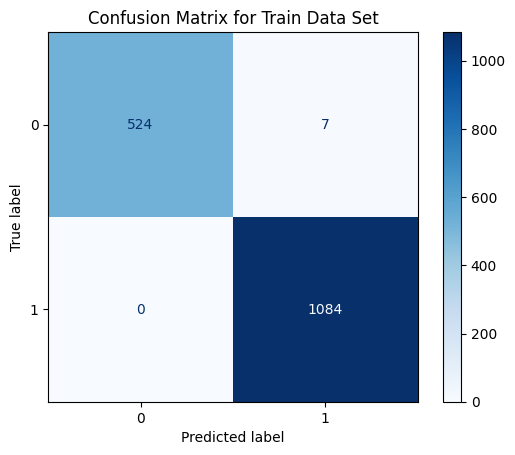

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_train).plot(include_values=True, cmap="Blues")
plt.title("Confusion Matrix for Train Data Set")
plt.show()

In [ ]:
conf_test = confusion_matrix(y_test, preds_test)
print('Confusion Matrix for testing set: ')
conf_test

Confusion Matrix for testing set: 


array([[ 98,  89],
       [ 14, 338]])

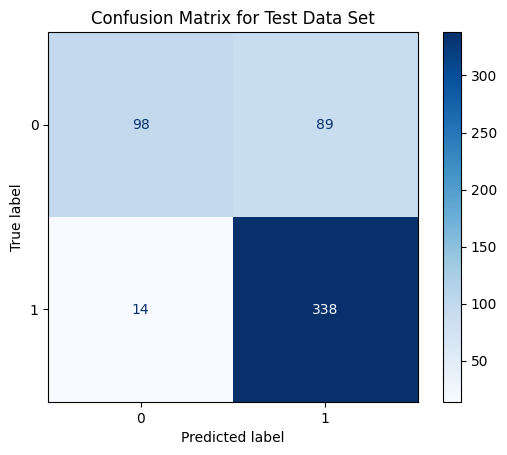

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_test).plot(include_values=True, cmap="Blues")
plt.title("Confusion Matrix for Test Data Set")
plt.show()

In [ ]:
f1_train = f1_score(y_train, preds_train)
f1_test = f1_score(y_test, preds_test)
print(f"F1_score for training set is : {f1_train}. \nF1_score for testing set is : {f1_test}.")

F1_score for training set is : 0.9967816091954023. 
F1_score for testing set is : 0.8677792041078306.
